In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import pathlib
import pickle
import random
import time

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.functional import interpolate
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.transforms.functional import adjust_brightness

from super_resolution.src.sen2venus_dataset import (
    create_train_test_split,
    create_train_validation_test_split,
    default_patch_transform,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, TruncatedVGG19, Discriminator

In [3]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

## Prepare Data

In [4]:
sites = {
    "SO2",
    # "ES-LTERA",
    # "FR-LAM",
    "FR-BIL",
    "NARYN",
}
train_patches, test_patches = create_train_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(
    f"Num train {len(train_patches)}\n"
    # f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 8159
Num test 3498


In [8]:
def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    x = torch.clamp(x, 0, 1)
    y = torch.clamp(y, 0, 1)

    return x, y

In [9]:
train_patches.set_transform(image_transform)
test_patches.set_transform(image_transform)

In [10]:
train_loader = DataLoader(train_patches, batch_size=100)

In [11]:
(low_res, high_res) = next(train_loader.__iter__())

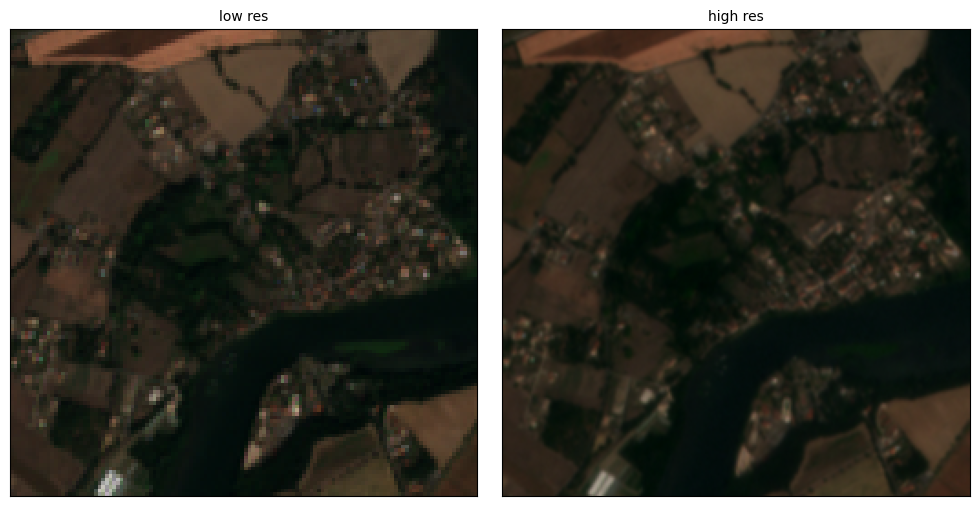

In [12]:
index = random.randint(0, len(low_res) - 1)
low_res_example = low_res[index]


high_res_example = high_res[index]


plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

## Training

In [311]:
# For clearing GPU memory
1 / 0

ZeroDivisionError: division by zero

In [ ]:
# For clearing GPU memory
import gc

gc.collect()
torch.cuda.empty_cache()

In [298]:
BATCH_SIZE = 16
GEN_LEARNING_RATE = 0.0001
DISCRIM_LEARNING_RATE = 0.0001

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,  # Always set to true for training
    batch_size=BATCH_SIZE,  # Always try to set as powers of 2
    drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
    pin_memory=should_pin_memory[device.type],  # Faster push to GPU
    num_workers=0,  # Load data in parallel but costs more memory
)

In [14]:
device

device(type='cuda')

In [18]:
generator = SRResNet(scaling_factor=2, n_blocks=8)

In [19]:
discriminator = Discriminator(n_blocks=2, fc_size=128)

In [299]:
generator = generator.to(device)
generator = generator.train()

In [21]:
discriminator = discriminator.to(device)
discriminator = discriminator.train()

In [300]:
gen_optimizer = optim.Adam(generator.parameters(), lr=GEN_LEARNING_RATE)
discrim_optimizer = optim.Adam(discriminator.parameters(), lr=DISCRIM_LEARNING_RATE)

In [ ]:
# save_file = RESULTS_DIR / "decentishsrgan_beforebatchnorm.pkl"
# loaded_experiment = torch.load(save_file, map_location=device)
# # generator = SRResNet(scaling_factor=2, n_blocks=4).to(device)
# generator.load_state_dict(loaded_experiment["gen_state"])
# discriminator.load_state_dict(loaded_experiment["discrim_state"])
# gen_optimizer.load_state_dict(loaded_experiment["gen_optimizer_state"])
# discrim_optimizer.load_state_dict(loaded_experiment["discrim_optimizer_state"])
# gen_losses = loaded_experiment["gen_epoch_losses"]
# discrim_losses = loaded_experiment["discrim_losses"]

In [23]:
pixel_criterion = nn.MSELoss()
discrim_criterion = nn.BCEWithLogitsLoss()

In [24]:
# vgg = TruncatedVGG19().to(device)
# vgg = vgg.eval()
# vgg = vgg.requires_grad_(False)

In [25]:
NUM_EPOCHS = 2000

In [26]:
train_time = 0.0
gen_losses = []
discrim_losses = []

In [301]:
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    gen_epoch_loss = 0.0
    discrim_epoch_loss = 0.0
    num_batches = 0
    for low_res_batch, high_res_batch in progress_bar:
        num_batches += 1
        start_time = time.time()

        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        # Update generator
        ############################################################################################
        super_resolved = generator(low_res_batch).clamp(0, 1)
        natural_probs = discriminator(super_resolved)

        pixel_loss = pixel_criterion(super_resolved, high_res_batch)
        discrim_loss = discrim_criterion(natural_probs, torch.ones_like(natural_probs))
        gen_loss = pixel_loss + 1e-3 * discrim_loss

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # Update discriminator
        ############################################################################################
        true_natural_probs = discriminator(high_res_batch)

        # Detach to skip generator computations
        fake_natural_probs = discriminator(super_resolved.detach())

        true_natural_loss = discrim_criterion(
            true_natural_probs, torch.ones_like(true_natural_probs)
        )
        fake_natural_loss = discrim_criterion(
            fake_natural_probs, torch.ones_like(fake_natural_probs)
        )
        adversarial_loss = true_natural_loss + fake_natural_loss

        # # Do not let discrim get too much advantage
        # if adversarial_loss.item() > 1e-03:
        #     discrim_optimizer.zero_grad()
        #     adversarial_loss.backward()
        #     discrim_optimizer.step()

        # Collect data
        gen_epoch_loss += gen_loss.item()
        discrim_epoch_loss += discrim_loss.item()
        progress_bar.set_postfix(
            epoch=epoch,
            gen_loss=f"{gen_epoch_loss/num_batches:.8f}",
            discrim_loss=f"{discrim_epoch_loss/num_batches:.8f}",
        )

        end_time = time.time()
        train_time += end_time - start_time

    gen_epoch_loss /= len(train_loader)
    discrim_epoch_loss /= len(train_loader)
    gen_losses.append(gen_epoch_loss)
    discrim_losses.append(discrim_epoch_loss)
    print(
        f"Epoch: {epoch} / gen_loss: {gen_epoch_loss:.8f} / discrim_loss: {discrim_epoch_loss:.8f}"
    )

100%|██████| 509/509 [09:48<00:00,  1.16s/it, discrim_loss=0.00019407, epoch=0, gen_loss=0.00002864]


Epoch: 0 / gen_loss: 0.00002864 / discrim_loss: 0.00019407


100%|██████| 509/509 [09:44<00:00,  1.15s/it, discrim_loss=0.00019821, epoch=1, gen_loss=0.00002831]


Epoch: 1 / gen_loss: 0.00002831 / discrim_loss: 0.00019821


100%|██████| 509/509 [09:23<00:00,  1.11s/it, discrim_loss=0.00019307, epoch=2, gen_loss=0.00002834]


Epoch: 2 / gen_loss: 0.00002834 / discrim_loss: 0.00019307


100%|██████| 509/509 [09:31<00:00,  1.12s/it, discrim_loss=0.00019690, epoch=3, gen_loss=0.00002835]


Epoch: 3 / gen_loss: 0.00002835 / discrim_loss: 0.00019690


100%|██████| 509/509 [08:59<00:00,  1.06s/it, discrim_loss=0.00019696, epoch=4, gen_loss=0.00002828]


Epoch: 4 / gen_loss: 0.00002828 / discrim_loss: 0.00019696


100%|██████| 509/509 [08:52<00:00,  1.05s/it, discrim_loss=0.00019468, epoch=5, gen_loss=0.00002845]


Epoch: 5 / gen_loss: 0.00002845 / discrim_loss: 0.00019468


100%|██████| 509/509 [08:56<00:00,  1.05s/it, discrim_loss=0.00019468, epoch=6, gen_loss=0.00002804]


Epoch: 6 / gen_loss: 0.00002804 / discrim_loss: 0.00019468


100%|██████| 509/509 [09:08<00:00,  1.08s/it, discrim_loss=0.00019598, epoch=7, gen_loss=0.00002829]


Epoch: 7 / gen_loss: 0.00002829 / discrim_loss: 0.00019598


100%|██████| 509/509 [09:12<00:00,  1.09s/it, discrim_loss=0.00019303, epoch=8, gen_loss=0.00002780]


Epoch: 8 / gen_loss: 0.00002780 / discrim_loss: 0.00019303


100%|██████| 509/509 [08:52<00:00,  1.05s/it, discrim_loss=0.00019351, epoch=9, gen_loss=0.00002788]


Epoch: 9 / gen_loss: 0.00002788 / discrim_loss: 0.00019351


100%|█████| 509/509 [09:33<00:00,  1.13s/it, discrim_loss=0.00019347, epoch=10, gen_loss=0.00002784]


Epoch: 10 / gen_loss: 0.00002784 / discrim_loss: 0.00019347


 49%|██▍  | 249/509 [04:34<04:46,  1.10s/it, discrim_loss=0.00019677, epoch=11, gen_loss=0.00002799]


KeyboardInterrupt: 

In [302]:
train_time / 60

343.2222263852755

In [303]:
len(gen_losses)

105

In [304]:
gen_losses[-5:]

[2.8041264508891584e-05,
 2.8292864500128706e-05,
 2.7803810764296135e-05,
 2.7878230204005235e-05,
 2.7838350199665558e-05]

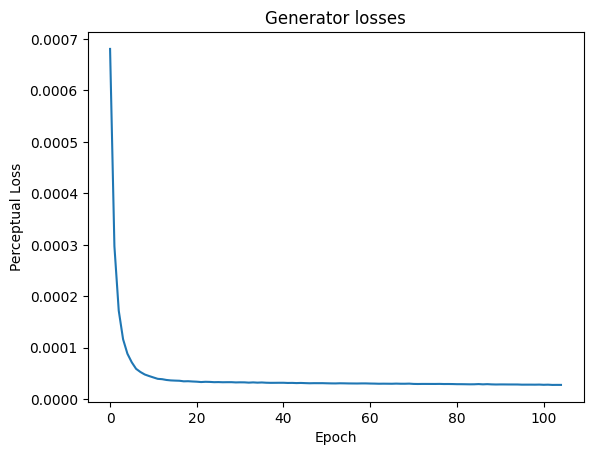

In [305]:
plt.plot(gen_losses)
plt.title("Generator losses")
plt.xlabel("Epoch")
plt.ylabel("Perceptual Loss")
plt.show()

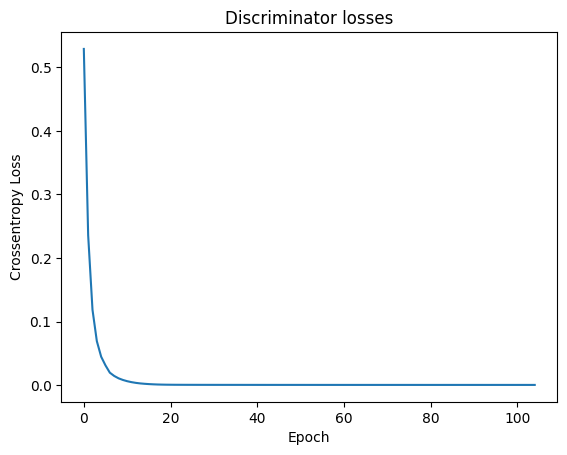

In [306]:
plt.plot(discrim_losses)
plt.title("Discriminator losses")
plt.xlabel("Epoch")
plt.ylabel("Crossentropy Loss")
plt.show()

## Saving

In [307]:
experiment = {
    "gen_losses": gen_losses,
    "discrim_losses": discrim_losses,
    "gen_state": generator.state_dict(),
    "discrim_state": discriminator.state_dict(),
    "gen_optimizer_state": gen_optimizer.state_dict(),
    "discrim_optimizer_state": discrim_optimizer.state_dict(),
    "gen_learning_rate": GEN_LEARNING_RATE,
    "discrim_learning_rate": DISCRIM_LEARNING_RATE,
}

In [308]:
save_file = RESULTS_DIR / "greatsrgan_withoutbatchnorm_firstbeatbicubic3_final.pkl"

In [309]:
if not save_file.exists():
    torch.save(experiment, save_file)
    print(f"Saved to {save_file}")

Saved to C:\Users\Mitch\stat3007_data\results\greatsrgan_withoutbatchnorm_firstbeatbicubic3_final.pkl


## Generated Examples

In [310]:
generator = generator.to("cpu")

In [311]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(loader.__iter__())

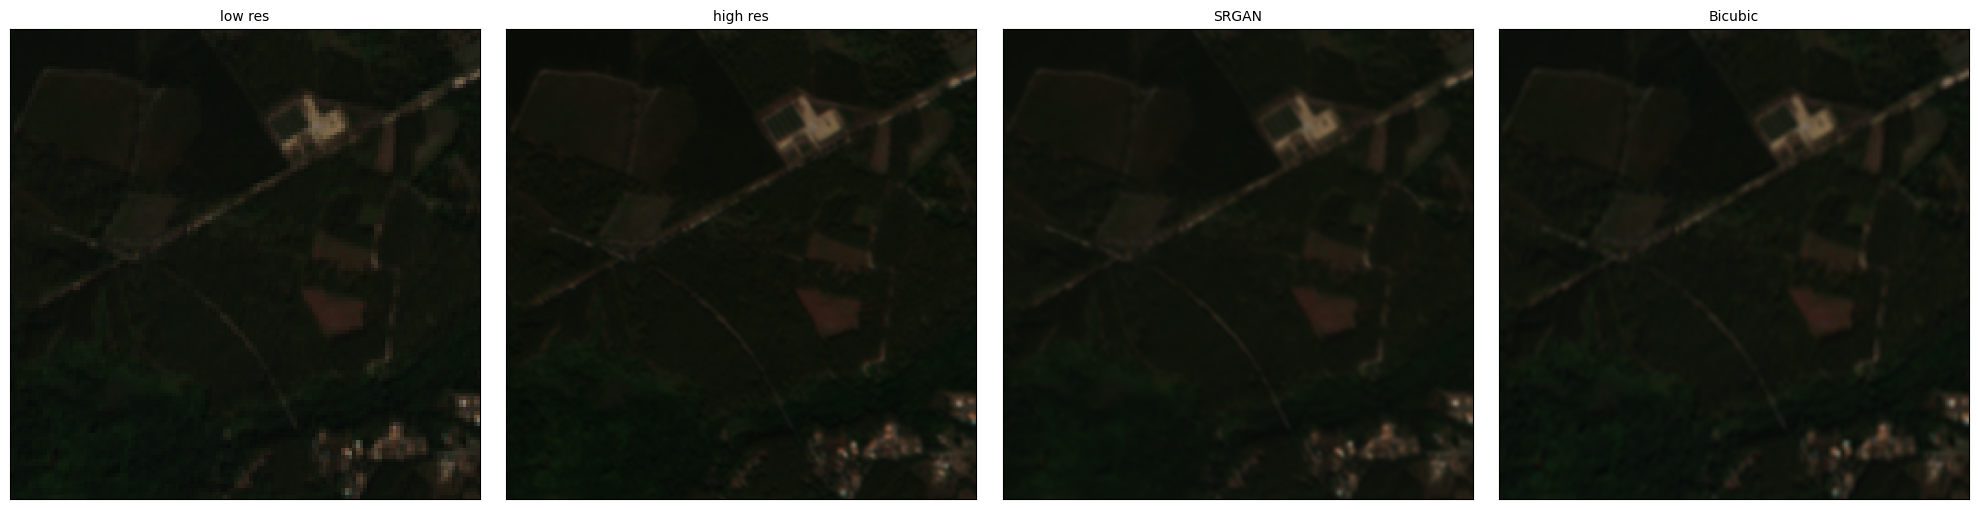

In [312]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = interpolate(
    low_res_example.unsqueeze(0),
    size=(256, 256),
    mode="bicubic",
).float()
plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [313]:
loader = DataLoader(test_patches, batch_size=100)
(low_res, high_res) = next(loader.__iter__())

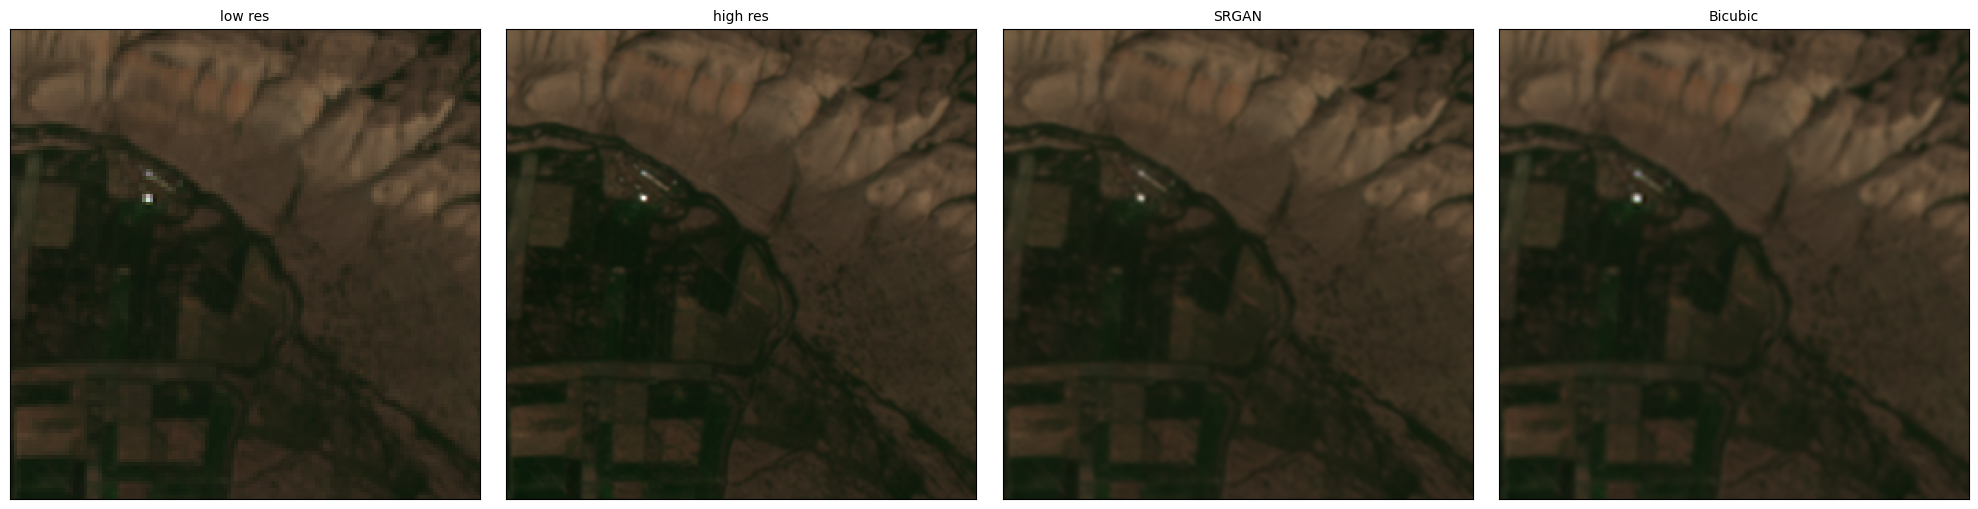

In [317]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = adjust_brightness(low_res[index], 2)
high_res_example = adjust_brightness(high_res[index], 2)

out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
out = adjust_brightness(out, 2)

bicubic_out = (
    interpolate(low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic")
    .float()
    .clamp(0, 1)
)
bicubic_out = adjust_brightness(bicubic_out, 2)

plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

## Save images

## Metrics

In [284]:
from super_resolution.src.testing import compute_metrics

In [285]:
# 256 is largest I can handle on cpu
metric_loader = DataLoader(test_patches, batch_size=min(len(test_patches), 256))

In [286]:
metrics = compute_metrics(lambda x: generator(x).clamp(0, 1), metric_loader)

100%|███████████████████████████████████████████████████████████████| 14/14 [15:47<00:00, 67.71s/it]


In [287]:
metrics

Metrics(mse=3.124712371313113e-05, psnr=45.06763458251953, ssim=0.9879355771200997, fid=0.9709701538085938)

In [ ]:
bicubic_metrics = compute_metrics(
    lambda x: interpolate(x, size=(256, 256), mode="bicubic"), metric_loader
)

In [ ]:
bicubic_metrics

Metrics(mse=4.024813668885534e-05, psnr=43.96280016217913, ssim=0.9836511441639492, fid=tensor(1.3964))